In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
import cv2

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")


# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Loading both the training and testing dataset:

In [2]:
CW_DATASET_PATH = "CW_dataset"

def load_data(dataset_path=CW_DATASET_PATH):
    x_train_all_path = os.path.join(dataset_path, "x_train_all.csv")
    y_train_all_path = os.path.join(dataset_path, "y_train_all.csv")
    x_test_all_path = os.path.join(dataset_path, "x_test_all.csv")
    y_test_all_path = os.path.join(dataset_path, "y_test_all.csv")

    x_train_all = pd.read_csv(x_train_all_path)
    y_train_all = pd.read_csv(y_train_all_path)
    x_test_all = pd.read_csv(x_test_all_path)
    y_test_all = pd.read_csv(y_test_all_path)

    return x_train_all, y_train_all,x_test_all,y_test_all

In [3]:
x_train, y_train,x_test, y_test = load_data()

In [4]:
x_train_normalized, x_test_normalized=np.array(x_train)/255, np.array(x_test)/255
x_train_reshaped = x_train_normalized.reshape((x_train_normalized.shape[0], 48, 48, 1))
x_test_reshaped = x_test_normalized.reshape((x_test_normalized.shape[0], 48, 48, 1))

In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score,roc_auc_score
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import roc_curve, auc

def calculate_metrics_and_mean(X_train, y_train, y_pred, model):
    report = classification_report(y_train, y_pred, output_dict=True,zero_division=0)
    report_df = pd.DataFrame(report).T.iloc[:-3].drop(columns='support')
    cm = confusion_matrix(y_train, y_pred)
    tp = np.diagonal(cm)
    fn = np.sum(cm, axis=1) - tp
    fp = np.sum(cm, axis=0) - tp
    tn = np.sum(cm) - (tp + fn + fp)
    tp_rate = tp / (tp + fn)
    fp_rate = fp / (fp + tn)
    tp_fp_rate_df = pd.DataFrame({'TPR': tp_rate, 'FPR': fp_rate}, index=range(len(tp_rate)))
    specificity = []
    unique_labels = np.unique(y_train)
    try:
        for i in range(len(unique_labels)):
            true_negative = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
            total_negative = np.sum(cm) - np.sum(cm[i, :])
            specificity.append(true_negative / total_negative)
        specificity_df = pd.DataFrame({'specificity': specificity}, index=unique_labels)
    except:
        specificity_df = pd.DataFrame({'specificity': np.nan}, index=unique_labels)
    try:
        sensitivity = recall_score(y_train, y_pred, average=None)
        sensitivity_df = pd.DataFrame({'sensitivity': sensitivity}, index=unique_labels)
    except:
        sensitivity_df = pd.DataFrame({'sensitivity': np.nan}, index=unique_labels)

    result_df = pd.concat([report_df.reset_index().drop(columns='index'),
                           tp_fp_rate_df.reset_index().drop(columns='index'),
                           specificity_df.reset_index().drop(columns='index'),
                           sensitivity_df.reset_index().drop(columns='index')], axis=1)
    
    try:
        probabilities=model.predict_proba(X_train)
        aucs= []
        for i in range(len(unique_labels)):
            fpr_dt, tpr_dt, _ = roc_curve((y_test == unique_labels[i]).astype(int), probabilities[:, i])
            roc_auc_dt = auc(fpr_dt, tpr_dt)
            aucs.append(roc_auc_dt)
    except:
        aucs = 0
    auc_df = pd.DataFrame({'AUC': aucs}, index=unique_labels)
    
    accuracy = accuracy_score(y_train, y_pred)
    accuracy_df = pd.DataFrame({'accuracy': [accuracy]})
    
    try:
        cross_val_scores = cross_val_score(model, X_train, y_train, cv=10)
    except :
        try:
            cross_val_scores = cross_val_predict(model, X_train, y_train, cv=10)
        except:
            cross_val_scores = [0]

    cross_val_mean = np.mean(cross_val_scores)
    cross_val_std = np.std(cross_val_scores)
    cross_val_df = pd.DataFrame({'CV mean': [cross_val_mean], 'CV std': [cross_val_std]})

    result_df = pd.concat([result_df, auc_df, accuracy_df, cross_val_df], axis=1)
    mean_values = pd.DataFrame(result_df.mean()).transpose()
    mean_values.index = ['mean']
    result_df = pd.concat([result_df, mean_values])
    
    return result_df

https://www.tensorflow.org/tutorials/images/cnn

https://colab.research.google.com/drive/1uWZQ-lzAk5308YVjMW5XaZcS_3zmGSgN?usp=sharing

In [6]:
import tensorflow as tf
from tensorflow.keras import  layers, models
import matplotlib.pyplot as plt
input_shape = x_train_reshaped.shape[1:]

def create_cnn(input_shape=input_shape, num_classes=10, dense_units=64, learning_rate=0.001, loss='sparse_categorical_crossentropy',
               kernel=(3, 3), strides=(2, 2), filters=32, metrics=['accuracy'],):
    model = models.Sequential()
    # convolutional input layer
    model.add(layers.Conv2D(filters, kernel, activation='relu', input_shape=input_shape, strides=strides))
    # pooling input layer
    model.add(layers.MaxPooling2D((2, 2)))
    # convolutional layer
    model.add(layers.Flatten())
    # fully connected layer
    model.add(layers.Dense(dense_units, activation='relu'))
    # fully connected output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


In [7]:
def plotHistory(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')

In [8]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
import pandas as pd

results_df=pd.DataFrame()

def cross_validate_and_evaluate(x_train, y_train, x_test, y_test,
                                 model,name='Model', epochs=10, batch_size=64):
    history = model.fit(x_train, y_train, epochs=epochs,
                         batch_size=batch_size, validation_data=(x_test_reshaped, y_test), verbose=0)
    
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    test_accuracy = accuracy_score(model.predict(x_test), y_test)
    train_accuracy = accuracy_score(model.predict(x_train), y_train)
    cv_accuracy = cross_val_score(model, x_train, y_train, cv=kf, scoring='accuracy', verbose=0).mean()

    results_dict = {'Model': name,
                    'CV10_Mean_Accuracy': cv_accuracy,
                    'Train_accuracy': train_accuracy,
                    'Test_accuracy': test_accuracy,
                    }
    global results_df 
    results_df = pd.concat([results_df, pd.DataFrame([results_dict])], ignore_index=True)
    return results_dict, history


C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\270069022.py:9: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,


31/31 [==============================] - 1s 24ms/step


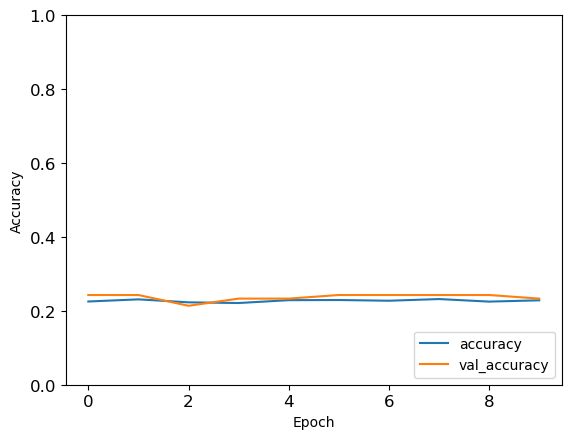

In [9]:
from keras.wrappers.scikit_learn import KerasClassifier

num_classes=10
epochs=10
batch_size=64
kernel=(3, 3)
strides=(2, 2)
input_shape=x_train_reshaped.shape[1:]
model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,
                         num_classes=num_classes,strides=strides,kernel=kernel,learning_rate=0.1)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model,
                                                    'M1 LR 0.1',epochs,batch_size)
plotHistory(history)

C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\2507795216.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,


31/31 [==============================] - 1s 24ms/step


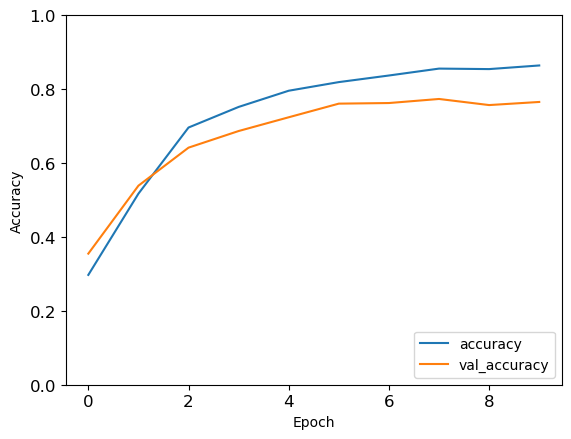

In [10]:
model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape, 
                        num_classes=num_classes,strides=strides,kernel=kernel,learning_rate=0.01)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model,
                                                    'M1 LR 0.01',epochs,batch_size)
plotHistory(history)

C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\2504390988.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,


31/31 [==============================] - 1s 27ms/step


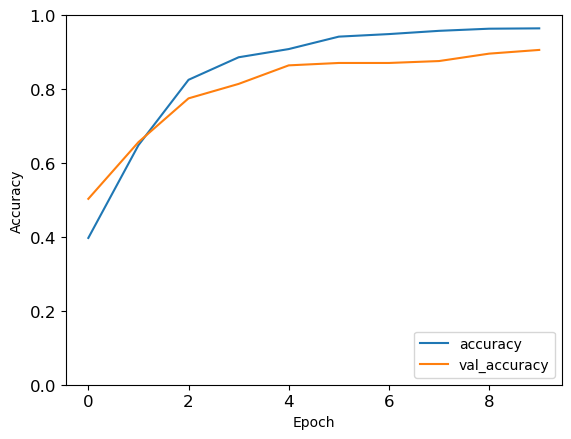

In [11]:
model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,
                         num_classes=num_classes,strides=strides,kernel=kernel,learning_rate=0.001)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model,
                                                    'M1 LR 0.001',epochs,batch_size)
plotHistory(history)

C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\3029777442.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,


31/31 [==============================] - 1s 30ms/step


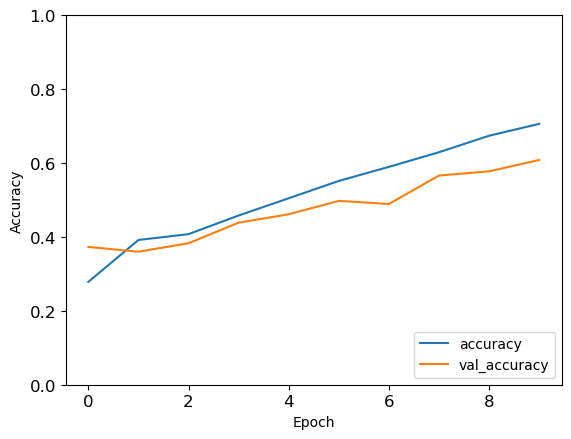

In [12]:
model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape, 
                        num_classes=num_classes,strides=strides,kernel=kernel,learning_rate=0.0001)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model,
                                                    'M1 LR 0.0001',epochs,batch_size)
plotHistory(history)

C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\103253170.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,


31/31 [==============================] - 1s 23ms/step


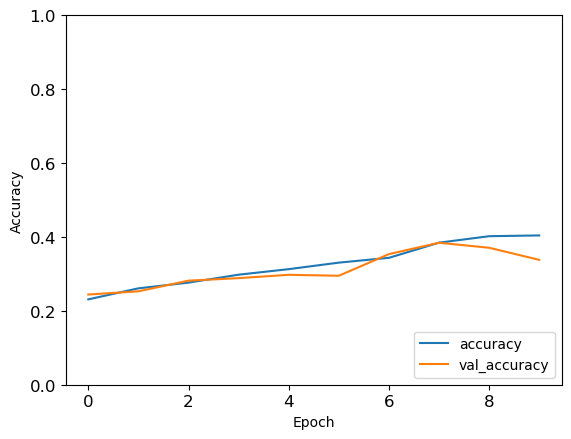

In [13]:
model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,
                         num_classes=num_classes,strides=strides,kernel=kernel,learning_rate=0.00001)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model, 
                                                  'M1 LR 0.00001',epochs,batch_size)
plotHistory(history)

In [14]:
results_df

,Model,CV10_Mean_Accuracy,Train_accuracy,Test_accuracy
0,M1 LR 0.1,0.224458,0.229102,0.233010
1,M1 LR 0.01,0.739628,0.882353,0.765049
2,M1 LR 0.001,0.621156,0.978947,0.905825
3,M1 LR 0.0001,0.398349,0.723839,0.608091
4,M1 LR 0.00001,0.257069,0.402167,0.337864


In [15]:
import tensorflow as tf
from tensorflow.keras import  layers, models
import matplotlib.pyplot as plt
input_shape = x_train_reshaped.shape[1:]

def create_cnn_ex(input_shape=input_shape, num_classes=10, dense_units=64,
                   learning_rate=0.001, loss='sparse_categorical_crossentropy',
                    kernel=(3, 3), strides=(2, 2), filters=32, metrics=['accuracy'],):
    model = models.Sequential()
    # convolutional input layer
    model.add(layers.Conv2D(filters, kernel, activation='relu', input_shape=input_shape, strides=strides))
    model.add(layers.Conv2D(filters, kernel, activation='relu',  strides=strides))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(filters, kernel, activation='relu',  strides=strides))
    model.add(layers.MaxPooling2D((2, 2)))
    # convolutional layer
    model.add(layers.Flatten())
    # fully connected layer
    model.add(layers.Dense(dense_units, activation='relu'))
    # fully connected output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\4150922143.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex, input_shape=input_shape,


31/31 [==============================] - 0s 4ms/step


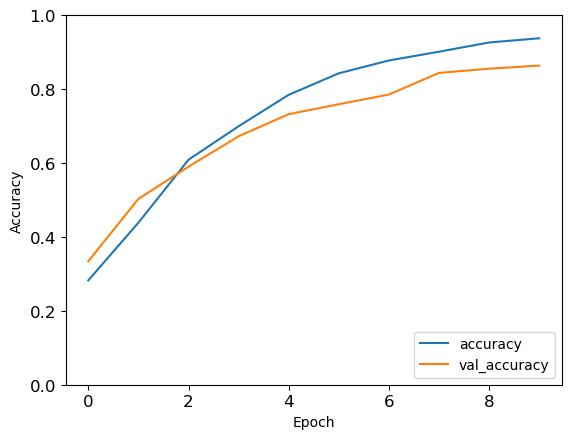

In [16]:
# best LR so far 0.001

model = KerasClassifier(build_fn=create_cnn_ex, input_shape=input_shape,
                         num_classes=num_classes,strides=strides,
                         kernel=kernel,learning_rate=0.001)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model, 
                                                  'M2 LR 0.001',epochs,batch_size)
plotHistory(history)

In [18]:
import tensorflow as tf
from tensorflow.keras import  layers, models
import matplotlib.pyplot as plt
input_shape = x_train_reshaped.shape[1:]

def create_cnn_ex2(input_shape=input_shape, num_classes=10, dense_units=64,
                    learning_rate=0.001, loss='sparse_categorical_crossentropy',
                    kernel=(3, 3), strides=(2, 2), filters=32, metrics=['accuracy'],):
    model = models.Sequential()
    # convolutional input layer
    model.add(layers.Conv2D(filters, kernel, activation='relu', input_shape=input_shape, strides=strides))
    model.add(layers.Conv2D(filters, kernel, activation='relu',  strides=strides))
    model.add(layers.MaxPooling2D((2, 2)))

    # convolutional layer
    model.add(layers.Flatten())
    # fully connected layer
    model.add(layers.Dense(dense_units, activation='relu'))
    # fully connected output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\451164647.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, input_shape=input_shape,


31/31 [==============================] - 0s 3ms/step


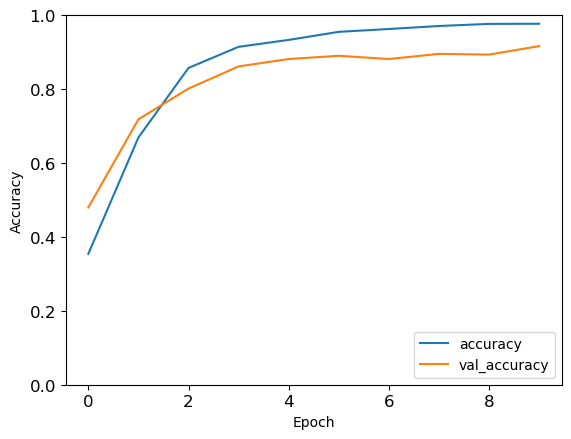

In [19]:
# best LR so far 0.001

model = KerasClassifier(build_fn=create_cnn_ex2, input_shape=input_shape,
                         num_classes=num_classes,strides=strides,
                         kernel=kernel,learning_rate=0.001)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model, 
                                                  'M3 LR 0.001 softmax',epochs,batch_size)
plotHistory(history)

https://adriangb.com/scikeras/stable/generated/scikeras.wrappers.KerasClassifier.html#scikeras.wrappers.KerasClassifier


#### Trying different activation fuctions on the output layer

In [20]:
import tensorflow as tf
from tensorflow.keras import  layers, models
import matplotlib.pyplot as plt
input_shape = x_train_reshaped.shape[1:]

def create_cnn_ex3(input_shape=input_shape, num_classes=10, dense_units=64,
                    learning_rate=0.001, loss='sparse_categorical_crossentropy',
                    kernel=(3, 3), strides=(2, 2), filters=32, metrics=['accuracy'],):
    model = models.Sequential()
    # convolutional input layer
    model.add(layers.Conv2D(filters, kernel, activation='relu', input_shape=input_shape, strides=strides))
    model.add(layers.Conv2D(filters, kernel, activation='relu',  strides=strides))
    model.add(layers.MaxPooling2D((2, 2)))

    # convolutional layer
    model.add(layers.Flatten())
    # fully connected layer
    model.add(layers.Dense(dense_units, activation='relu'))
    # fully connected output layer
    model.add(layers.Dense(num_classes, activation='sigmoid'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\2008646502.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex3, input_shape=input_shape,


31/31 [==============================] - 0s 3ms/step


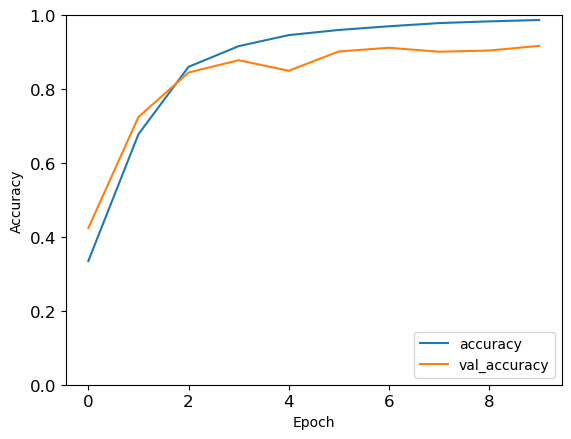

In [21]:
# best LR so far 0.001

model = KerasClassifier(build_fn=create_cnn_ex3, input_shape=input_shape,
                         num_classes=num_classes,strides=strides,
                         kernel=kernel,learning_rate=0.001)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model, 
                                                  'M3 LR 0.001 sigmoid',epochs,batch_size)
plotHistory(history)

In [22]:
import tensorflow as tf
from tensorflow.keras import  layers, models
import matplotlib.pyplot as plt
input_shape = x_train_reshaped.shape[1:]

def create_cnn_ex4(input_shape=input_shape, num_classes=10, dense_units=64,
                    learning_rate=0.001, loss='sparse_categorical_crossentropy',
                    kernel=(3, 3), strides=(2, 2), filters=32, metrics=['accuracy'],):
    model = models.Sequential()
    # convolutional input layer
    model.add(layers.Conv2D(filters, kernel, activation='relu', input_shape=input_shape, strides=strides))
    model.add(layers.Conv2D(filters, kernel, activation='relu',  strides=strides))
    model.add(layers.MaxPooling2D((2, 2)))

    # convolutional layer
    model.add(layers.Flatten())
    # fully connected layer
    model.add(layers.Dense(dense_units, activation='relu'))
    # fully connected output layer
    model.add(layers.Dense(num_classes, activation='linear'))  #basically no activation functon as it has no effect on the weights
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\695072473.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex4, input_shape=input_shape,


31/31 [==============================] - 0s 2ms/step


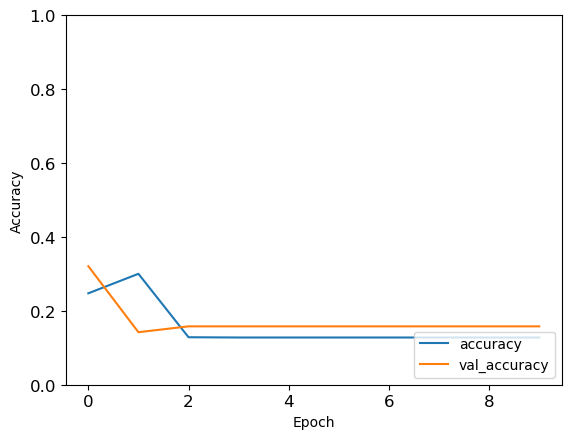

In [23]:
# best LR so far 0.001

model = KerasClassifier(build_fn=create_cnn_ex4, input_shape=input_shape,
                         num_classes=num_classes,strides=strides,
                         kernel=kernel,learning_rate=0.001)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model, 
                                                  'M3 LR 0.001 linear',epochs,batch_size)
plotHistory(history)

## ______________________


In [24]:
"""
#best scores for all 3 but big overfit
def create_cnn_ex5(input_shape=input_shape, num_classes=10, dense_units=64,
                    learning_rate=0.001, loss='sparse_categorical_crossentropy',
                    kernel=(3, 3), strides=(2, 2), filters=32, metrics=['accuracy'],):
    model = models.Sequential()
    # convolutional input layer
    model.add(layers.Conv2D(filters, kernel, activation='selu', input_shape=input_shape, strides=strides))
    model.add(layers.Conv2D(filters, kernel, activation='selu',  strides=strides))
    model.add(layers.MaxPooling2D((2, 2)))

    # convolutional layer
    model.add(layers.Flatten())
    # fully connected layer
    model.add(layers.Dense(dense_units, activation='selu'))
    # fully connected output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model
"""


"\n#best scores for all 3 but big overfit\ndef create_cnn_ex5(input_shape=input_shape, num_classes=10, dense_units=64,\n                    learning_rate=0.001, loss='sparse_categorical_crossentropy',\n                    kernel=(3, 3), strides=(2, 2), filters=32, metrics=['accuracy'],):\n    model = models.Sequential()\n    # convolutional input layer\n    model.add(layers.Conv2D(filters, kernel, activation='selu', input_shape=input_shape, strides=strides))\n    model.add(layers.Conv2D(filters, kernel, activation='selu',  strides=strides))\n    model.add(layers.MaxPooling2D((2, 2)))\n\n    # convolutional layer\n    model.add(layers.Flatten())\n    # fully connected layer\n    model.add(layers.Dense(dense_units, activation='selu'))\n    # fully connected output layer\n    model.add(layers.Dense(num_classes, activation='softmax'))\n    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)\n    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)\n    return model\

In [25]:
"""
model = KerasClassifier(build_fn=create_cnn_ex5, input_shape=input_shape,
                         num_classes=num_classes,strides=strides,
                         kernel=kernel,learning_rate=0.001)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model, 
                                                  'M4 LR 0.001',epochs,batch_size)

plotHistory(history)

"""


"\nmodel = KerasClassifier(build_fn=create_cnn_ex5, input_shape=input_shape,\n                         num_classes=num_classes,strides=strides,\n                         kernel=kernel,learning_rate=0.001)\nresults_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,\n                                                  x_test_reshaped, y_test,model, \n                                                  'M4 LR 0.001',epochs,batch_size)\n\nplotHistory(history)\n\n"

In [26]:
def create_cnn_ex6(input_shape=input_shape, num_classes=10, dense_units=64,
                    learning_rate=0.001, loss='sparse_categorical_crossentropy',
                    kernel=(3, 3), strides=(2, 2), filters=32, metrics=['accuracy'],):
    model = models.Sequential()
    # convolutional input layer
    model.add(layers.Conv2D(filters, kernel, activation='selu', input_shape=input_shape, strides=strides))
    model.add(layers.Conv2D(filters, kernel, activation='selu',  strides=strides))
    model.add(layers.MaxPooling2D((2, 2)))

    # convolutional layer
    model.add(layers.Flatten())
    # fully connected layer
    model.add(layers.Dense(dense_units, activation='selu'))
    # fully connected output layer
    model.add(layers.Dense(num_classes, activation='selu'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\2041653446.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex6, input_shape=input_shape,


31/31 [==============================] - 0s 4ms/step


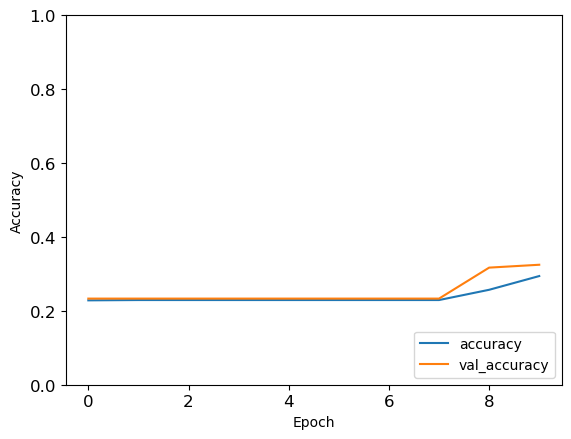

In [27]:

model = KerasClassifier(build_fn=create_cnn_ex6, input_shape=input_shape,
                         num_classes=num_classes,strides=strides,
                         kernel=kernel,learning_rate=0.001)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model, 
                                                  'M5 LR 0.001',epochs,batch_size)

plotHistory(history)


In [28]:
results_df

,Model,CV10_Mean_Accuracy,Train_accuracy,Test_accuracy
0,M1 LR 0.1,0.224458,0.229102,0.233010
1,M1 LR 0.01,0.739628,0.882353,0.765049
2,M1 LR 0.001,0.621156,0.978947,0.905825
3,M1 LR 0.0001,0.398349,0.723839,0.608091
4,M1 LR 0.00001,0.257069,0.402167,0.337864
5,M2 LR 0.001,0.383075,0.950980,0.863430
6,M3 LR 0.001 softmax,0.621878,0.987616,0.916181
7,M3 LR 0.001 sigmoid,0.598142,0.766460,0.736570
8,M3 LR 0.001 linear,0.104334,0.127761,0.157929
9,M5 LR 0.001,0.158720,0.302167,0.324595


In [29]:
from sklearn.model_selection import ParameterGrid



param_grid = {
    'epochs': [1,2,5],
    'learning_rate': [0.001],
    'kernel': [(3, 3), (5, 5)],
    'strides': [(1, 1), (2, 2)],
    'dense_units': [64, 128],
}
i=0
best_accuracy = 0
best_params = {}
for params in ParameterGrid(param_grid):
    print(i)
    model = KerasClassifier(build_fn=create_cnn_ex2, **params)
    results_dict, history = cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model, 
                                                  f'M3 CVsearch {i}',epochs,batch_size)
    if results_dict['Test_accuracy'] > best_accuracy:
        best_accuracy = results_dict['Test_accuracy'] 
        best_params = params
    i+=1

0


C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\101410623.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


31/31 [==============================] - 1s 39ms/step
1


C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\101410623.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


31/31 [==============================] - 0s 2ms/step
2


C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\101410623.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


31/31 [==============================] - 2s 47ms/step
3


C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\101410623.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


31/31 [==============================] - 0s 4ms/step
4


C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\101410623.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


303/303 [==============================] - 10s 32ms/step
Epoch 1/2
273/273 [==============================] - 19s 68ms/step - loss: 0.9456 - accuracy: 0.6763
Epoch 2/2
31/31 [==============================] - 1s 44ms/step
Epoch 1/2
273/273 [==============================] - 21s 77ms/step - loss: 0.9607 - accuracy: 0.6703
Epoch 2/2
31/31 [==============================] - 1s 41ms/step
Epoch 1/2
273/273 [==============================] - 19s 69ms/step - loss: 0.9242 - accuracy: 0.6827
Epoch 2/2
31/31 [==============================] - 1s 32ms/step
Epoch 1/2
273/273 [==============================] - 20s 71ms/step - loss: 0.8022 - accuracy: 0.7185
Epoch 2/2
31/31 [==============================] - 2s 49ms/step
Epoch 1/2
273/273 [==============================] - 22s 78ms/step - loss: 0.8095 - accuracy: 0.7214
Epoch 2/2
31/31 [==============================] - 1s 41ms/step
Epoch 1/2
273/273 [==============================] - 19s 68ms/step - loss: 0.7989 - accuracy: 0.7362
Epoch 2/2
31/31 [

C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\101410623.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


303/303 [==============================] - 2s 5ms/step
Epoch 1/2
273/273 [==============================] - 3s 9ms/step - loss: 1.5845 - accuracy: 0.4099
Epoch 2/2
31/31 [==============================] - 0s 3ms/step
Epoch 1/2
273/273 [==============================] - 3s 8ms/step - loss: 1.5963 - accuracy: 0.4177
Epoch 2/2
31/31 [==============================] - 0s 3ms/step
Epoch 1/2
273/273 [==============================] - 3s 8ms/step - loss: 1.6152 - accuracy: 0.3700
Epoch 2/2
31/31 [==============================] - 0s 3ms/step
Epoch 1/2
273/273 [==============================] - 3s 8ms/step - loss: 1.6510 - accuracy: 0.3813
Epoch 2/2
31/31 [==============================] - 0s 4ms/step
Epoch 1/2
273/273 [==============================] - 3s 7ms/step - loss: 1.5609 - accuracy: 0.4288
Epoch 2/2
31/31 [==============================] - 0s 4ms/step
Epoch 1/2
273/273 [==============================] - 3s 8ms/step - loss: 1.5589 - accuracy: 0.4178
Epoch 2/2
31/31 [===================

C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\101410623.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


303/303 [==============================] - 13s 43ms/step
Epoch 1/2
273/273 [==============================] - 26s 94ms/step - loss: 0.9762 - accuracy: 0.6718
Epoch 2/2
31/31 [==============================] - 2s 47ms/step
Epoch 1/2
273/273 [==============================] - 33s 119ms/step - loss: 0.7359 - accuracy: 0.7517
Epoch 2/2
31/31 [==============================] - 1s 42ms/step
Epoch 1/2
273/273 [==============================] - 26s 95ms/step - loss: 0.8564 - accuracy: 0.7075
Epoch 2/2
31/31 [==============================] - 2s 53ms/step
Epoch 1/2
273/273 [==============================] - 33s 120ms/step - loss: 0.8533 - accuracy: 0.7107
Epoch 2/2
31/31 [==============================] - 1s 44ms/step
Epoch 1/2
273/273 [==============================] - 27s 96ms/step - loss: 0.8169 - accuracy: 0.7255
Epoch 2/2
31/31 [==============================] - 2s 47ms/step
Epoch 1/2
273/273 [==============================] - 33s 119ms/step - loss: 0.8217 - accuracy: 0.7237
Epoch 2/2
31/3

C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\101410623.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


303/303 [==============================] - 2s 6ms/step
Epoch 1/2
273/273 [==============================] - 5s 12ms/step - loss: 1.2000 - accuracy: 0.5934
Epoch 2/2
31/31 [==============================] - 0s 7ms/step
Epoch 1/2
273/273 [==============================] - 5s 13ms/step - loss: 1.5836 - accuracy: 0.4175
Epoch 2/2
31/31 [==============================] - 0s 5ms/step
Epoch 1/2
273/273 [==============================] - 6s 12ms/step - loss: 1.4627 - accuracy: 0.4987
Epoch 2/2
31/31 [==============================] - 0s 6ms/step
Epoch 1/2
273/273 [==============================] - 5s 14ms/step - loss: 1.4845 - accuracy: 0.4630
Epoch 2/2
31/31 [==============================] - 0s 6ms/step
Epoch 1/2
273/273 [==============================] - 5s 12ms/step - loss: 1.4395 - accuracy: 0.4794
Epoch 2/2
31/31 [==============================] - 0s 6ms/step
Epoch 1/2
273/273 [==============================] - 5s 12ms/step - loss: 1.2735 - accuracy: 0.5529
Epoch 2/2
31/31 [=============

C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\101410623.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


303/303 [==============================] - 14s 47ms/step
Epoch 1/5
273/273 [==============================] - 27s 93ms/step - loss: 0.8288 - accuracy: 0.7232
Epoch 2/5
273/273 [==============================] - 26s 94ms/step - loss: 0.1754 - accuracy: 0.9485
Epoch 3/5
273/273 [==============================] - 27s 100ms/step - loss: 0.0996 - accuracy: 0.9696
Epoch 4/5
273/273 [==============================] - 26s 95ms/step - loss: 0.0458 - accuracy: 0.9881
Epoch 5/5
31/31 [==============================] - 2s 48ms/step
Epoch 1/5
273/273 [==============================] - 28s 96ms/step - loss: 0.9637 - accuracy: 0.6666
Epoch 2/5
273/273 [==============================] - 27s 97ms/step - loss: 0.1714 - accuracy: 0.9508
Epoch 3/5
273/273 [==============================] - 27s 97ms/step - loss: 0.1004 - accuracy: 0.9708
Epoch 4/5
273/273 [==============================] - 26s 96ms/step - loss: 0.0700 - accuracy: 0.9794
Epoch 5/5
31/31 [==============================] - 1s 40ms/step
Epoch 

C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\101410623.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


303/303 [==============================] - 2s 5ms/step
Epoch 1/5
273/273 [==============================] - 5s 12ms/step - loss: 1.5320 - accuracy: 0.4206
Epoch 2/5
273/273 [==============================] - 3s 11ms/step - loss: 0.6370 - accuracy: 0.7866
Epoch 3/5
273/273 [==============================] - 3s 12ms/step - loss: 0.3339 - accuracy: 0.8973
Epoch 4/5
273/273 [==============================] - 3s 12ms/step - loss: 0.2148 - accuracy: 0.9362
Epoch 5/5
31/31 [==============================] - 0s 6ms/step
Epoch 1/5
273/273 [==============================] - 5s 11ms/step - loss: 1.5142 - accuracy: 0.4307
Epoch 2/5
273/273 [==============================] - 3s 10ms/step - loss: 0.6176 - accuracy: 0.7962
Epoch 3/5
273/273 [==============================] - 3s 11ms/step - loss: 0.3491 - accuracy: 0.8906
Epoch 4/5
273/273 [==============================] - 3s 12ms/step - loss: 0.2438 - accuracy: 0.9259
Epoch 5/5
31/31 [==============================] - 0s 5ms/step
Epoch 1/5
273/273 [

C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\101410623.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


303/303 [==============================] - 15s 48ms/step
Epoch 1/5
273/273 [==============================] - 28s 101ms/step - loss: 0.7543 - accuracy: 0.7542
Epoch 2/5
273/273 [==============================] - 31s 114ms/step - loss: 0.1338 - accuracy: 0.9609
Epoch 3/5
273/273 [==============================] - 28s 101ms/step - loss: 0.0618 - accuracy: 0.9830
Epoch 4/5
273/273 [==============================] - 27s 97ms/step - loss: 0.0429 - accuracy: 0.9883
Epoch 5/5
31/31 [==============================] - 2s 49ms/step
Epoch 1/5
273/273 [==============================] - 28s 100ms/step - loss: 1.0273 - accuracy: 0.6386
Epoch 2/5
273/273 [==============================] - 27s 101ms/step - loss: 0.1696 - accuracy: 0.9525
Epoch 3/5
273/273 [==============================] - 32s 117ms/step - loss: 0.0736 - accuracy: 0.9803
Epoch 4/5
273/273 [==============================] - 30s 111ms/step - loss: 0.0450 - accuracy: 0.9880
Epoch 5/5
31/31 [==============================] - 2s 51ms/step


C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\101410623.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


303/303 [==============================] - 2s 5ms/step
Epoch 1/5
273/273 [==============================] - 4s 12ms/step - loss: 1.4232 - accuracy: 0.5099
Epoch 2/5
273/273 [==============================] - 4s 13ms/step - loss: 0.3605 - accuracy: 0.8977
Epoch 3/5
273/273 [==============================] - 4s 15ms/step - loss: 0.1743 - accuracy: 0.9552
Epoch 4/5
273/273 [==============================] - 4s 14ms/step - loss: 0.1096 - accuracy: 0.9714
Epoch 5/5
31/31 [==============================] - 0s 6ms/step
Epoch 1/5
273/273 [==============================] - 4s 12ms/step - loss: 1.3149 - accuracy: 0.5361
Epoch 2/5
273/273 [==============================] - 4s 15ms/step - loss: 0.3197 - accuracy: 0.9103
Epoch 3/5
273/273 [==============================] - 4s 15ms/step - loss: 0.1663 - accuracy: 0.9547
Epoch 4/5
273/273 [==============================] - 4s 14ms/step - loss: 0.1104 - accuracy: 0.9701
Epoch 5/5
31/31 [==============================] - 0s 5ms/step
Epoch 1/5
273/273 [

C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\101410623.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


31/31 [==============================] - 1s 20ms/step
13


C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\101410623.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


31/31 [==============================] - 0s 4ms/step
14


C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\101410623.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


31/31 [==============================] - 1s 24ms/step
15


C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\101410623.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


31/31 [==============================] - 0s 4ms/step
16


C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\101410623.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


303/303 [==============================] - 6s 21ms/step
Epoch 1/2
273/273 [==============================] - 18s 63ms/step - loss: 0.6838 - accuracy: 0.7686
Epoch 2/2
31/31 [==============================] - 1s 17ms/step
Epoch 1/2
273/273 [==============================] - 15s 53ms/step - loss: 0.8045 - accuracy: 0.7214
Epoch 2/2
31/31 [==============================] - 1s 16ms/step
Epoch 1/2
273/273 [==============================] - 17s 60ms/step - loss: 0.7409 - accuracy: 0.7534
Epoch 2/2
31/31 [==============================] - 2s 43ms/step
Epoch 1/2
273/273 [==============================] - 26s 87ms/step - loss: 0.9431 - accuracy: 0.6711
Epoch 2/2
31/31 [==============================] - 1s 17ms/step
Epoch 1/2
273/273 [==============================] - 17s 59ms/step - loss: 0.7780 - accuracy: 0.7401
Epoch 2/2
31/31 [==============================] - 1s 18ms/step
Epoch 1/2
273/273 [==============================] - 17s 60ms/step - loss: 0.7517 - accuracy: 0.7431
Epoch 2/2
31/31 [=

C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\101410623.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


303/303 [==============================] - 1s 3ms/step
Epoch 1/2
273/273 [==============================] - 3s 8ms/step - loss: 1.4368 - accuracy: 0.4647
Epoch 2/2
31/31 [==============================] - 0s 3ms/step
Epoch 1/2
273/273 [==============================] - 3s 7ms/step - loss: 1.5383 - accuracy: 0.4372
Epoch 2/2
31/31 [==============================] - 0s 3ms/step
Epoch 1/2
273/273 [==============================] - 3s 8ms/step - loss: 1.5174 - accuracy: 0.4329
Epoch 2/2
31/31 [==============================] - 0s 3ms/step
Epoch 1/2
273/273 [==============================] - 3s 7ms/step - loss: 1.5284 - accuracy: 0.4279
Epoch 2/2
31/31 [==============================] - 0s 3ms/step
Epoch 1/2
273/273 [==============================] - 3s 7ms/step - loss: 1.5106 - accuracy: 0.4250
Epoch 2/2
31/31 [==============================] - 0s 3ms/step
Epoch 1/2
273/273 [==============================] - 3s 8ms/step - loss: 1.3652 - accuracy: 0.5025
Epoch 2/2
31/31 [===================

C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\101410623.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


303/303 [==============================] - 8s 26ms/step
Epoch 1/2
273/273 [==============================] - 23s 81ms/step - loss: 0.6798 - accuracy: 0.7714
Epoch 2/2
31/31 [==============================] - 1s 30ms/step
Epoch 1/2
273/273 [==============================] - 23s 81ms/step - loss: 0.7482 - accuracy: 0.7488
Epoch 2/2
31/31 [==============================] - 1s 27ms/step
Epoch 1/2
273/273 [==============================] - 23s 82ms/step - loss: 0.6921 - accuracy: 0.7692
Epoch 2/2
31/31 [==============================] - 1s 26ms/step
Epoch 1/2
273/273 [==============================] - 22s 80ms/step - loss: 0.7355 - accuracy: 0.7501
Epoch 2/2
31/31 [==============================] - 1s 26ms/step
Epoch 1/2
273/273 [==============================] - 23s 83ms/step - loss: 0.6803 - accuracy: 0.7694
Epoch 2/2
31/31 [==============================] - 1s 31ms/step
Epoch 1/2
273/273 [==============================] - 24s 86ms/step - loss: 0.6455 - accuracy: 0.7831
Epoch 2/2
31/31 [=

C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\101410623.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


303/303 [==============================] - 1s 3ms/step
Epoch 1/2
273/273 [==============================] - 3s 9ms/step - loss: 1.3312 - accuracy: 0.5350
Epoch 2/2
31/31 [==============================] - 0s 3ms/step
Epoch 1/2
273/273 [==============================] - 3s 9ms/step - loss: 1.2500 - accuracy: 0.5575
Epoch 2/2
31/31 [==============================] - 0s 3ms/step
Epoch 1/2
273/273 [==============================] - 3s 9ms/step - loss: 1.3420 - accuracy: 0.5134
Epoch 2/2
31/31 [==============================] - 0s 3ms/step
Epoch 1/2
273/273 [==============================] - 3s 9ms/step - loss: 1.4579 - accuracy: 0.4727
Epoch 2/2
31/31 [==============================] - 0s 3ms/step
Epoch 1/2
273/273 [==============================] - 3s 9ms/step - loss: 1.3397 - accuracy: 0.5220
Epoch 2/2
31/31 [==============================] - 0s 3ms/step
Epoch 1/2
273/273 [==============================] - 3s 9ms/step - loss: 1.2077 - accuracy: 0.5769
Epoch 2/2
31/31 [===================

C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\101410623.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


303/303 [==============================] - 4s 14ms/step
Epoch 1/5
273/273 [==============================] - 13s 46ms/step - loss: 0.7850 - accuracy: 0.7294
Epoch 2/5
273/273 [==============================] - 13s 49ms/step - loss: 0.1337 - accuracy: 0.9622
Epoch 3/5
273/273 [==============================] - 13s 48ms/step - loss: 0.0689 - accuracy: 0.9804
Epoch 4/5
273/273 [==============================] - 13s 47ms/step - loss: 0.0436 - accuracy: 0.9874
Epoch 5/5
31/31 [==============================] - 1s 14ms/step
Epoch 1/5
273/273 [==============================] - 13s 46ms/step - loss: 0.7908 - accuracy: 0.7270
Epoch 2/5
273/273 [==============================] - 13s 46ms/step - loss: 0.1317 - accuracy: 0.9611
Epoch 3/5
273/273 [==============================] - 13s 46ms/step - loss: 0.0714 - accuracy: 0.9794
Epoch 4/5
273/273 [==============================] - 13s 46ms/step - loss: 0.0614 - accuracy: 0.9811
Epoch 5/5
31/31 [==============================] - 1s 13ms/step
Epoch 1/

C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\101410623.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


303/303 [==============================] - 1s 3ms/step
Epoch 1/5
273/273 [==============================] - 2s 7ms/step - loss: 1.4819 - accuracy: 0.4542
Epoch 2/5
273/273 [==============================] - 2s 7ms/step - loss: 0.5029 - accuracy: 0.8416
Epoch 3/5
273/273 [==============================] - 2s 7ms/step - loss: 0.2626 - accuracy: 0.9201
Epoch 4/5
273/273 [==============================] - 2s 7ms/step - loss: 0.1688 - accuracy: 0.9495
Epoch 5/5
31/31 [==============================] - 0s 3ms/step
Epoch 1/5
273/273 [==============================] - 2s 7ms/step - loss: 1.4507 - accuracy: 0.4635
Epoch 2/5
273/273 [==============================] - 2s 7ms/step - loss: 0.5117 - accuracy: 0.8387
Epoch 3/5
273/273 [==============================] - 2s 7ms/step - loss: 0.2436 - accuracy: 0.9279
Epoch 4/5
273/273 [==============================] - 2s 7ms/step - loss: 0.1790 - accuracy: 0.9439
Epoch 5/5
31/31 [==============================] - 0s 3ms/step
Epoch 1/5
273/273 [========

C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\101410623.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


303/303 [==============================] - 8s 25ms/step
Epoch 1/5
273/273 [==============================] - 21s 74ms/step - loss: 0.7741 - accuracy: 0.7405
Epoch 2/5
273/273 [==============================] - 21s 76ms/step - loss: 0.1093 - accuracy: 0.9701
Epoch 3/5
273/273 [==============================] - 21s 76ms/step - loss: 0.0634 - accuracy: 0.9821
Epoch 4/5
273/273 [==============================] - 20s 75ms/step - loss: 0.0428 - accuracy: 0.9881
Epoch 5/5
31/31 [==============================] - 1s 22ms/step
Epoch 1/5
273/273 [==============================] - 22s 78ms/step - loss: 0.7327 - accuracy: 0.7443
Epoch 2/5
273/273 [==============================] - 25s 92ms/step - loss: 0.1236 - accuracy: 0.9645
Epoch 3/5
273/273 [==============================] - 26s 94ms/step - loss: 0.0606 - accuracy: 0.9828
Epoch 4/5
273/273 [==============================] - 23s 85ms/step - loss: 0.0266 - accuracy: 0.9929
Epoch 5/5
31/31 [==============================] - 1s 27ms/step
Epoch 1/

C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\101410623.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


303/303 [==============================] - 2s 5ms/step
Epoch 1/5
273/273 [==============================] - 4s 12ms/step - loss: 1.2344 - accuracy: 0.5604
Epoch 2/5
273/273 [==============================] - 3s 12ms/step - loss: 0.2674 - accuracy: 0.9232
Epoch 3/5
273/273 [==============================] - 3s 12ms/step - loss: 0.1342 - accuracy: 0.9640
Epoch 4/5
273/273 [==============================] - 3s 11ms/step - loss: 0.0781 - accuracy: 0.9800
Epoch 5/5
31/31 [==============================] - 0s 11ms/step
Epoch 1/5
273/273 [==============================] - 4s 13ms/step - loss: 1.2760 - accuracy: 0.5484
Epoch 2/5
273/273 [==============================] - 4s 16ms/step - loss: 0.2842 - accuracy: 0.9188
Epoch 3/5
273/273 [==============================] - 3s 11ms/step - loss: 0.1356 - accuracy: 0.9622
Epoch 4/5
273/273 [==============================] - 4s 14ms/step - loss: 0.0794 - accuracy: 0.9787
Epoch 5/5
31/31 [==============================] - 1s 8ms/step
Epoch 1/5
273/273 

In [30]:
results_df

,Model,CV10_Mean_Accuracy,Train_accuracy,Test_accuracy
0,M1 LR 0.1,0.224458,0.229102,0.233010
1,M1 LR 0.01,0.739628,0.882353,0.765049
2,M1 LR 0.001,0.621156,0.978947,0.905825
3,M1 LR 0.0001,0.398349,0.723839,0.608091
4,M1 LR 0.00001,0.257069,0.402167,0.337864
5,M2 LR 0.001,0.383075,0.950980,0.863430
6,M3 LR 0.001 softmax,0.621878,0.987616,0.916181
7,M3 LR 0.001 sigmoid,0.598142,0.766460,0.736570
8,M3 LR 0.001 linear,0.104334,0.127761,0.157929
9,M5 LR 0.001,0.158720,0.302167,0.324595


In [31]:
best_params

{'dense_units': 64,
 'epochs': 1,
 'kernel': (5, 5),
 'learning_rate': 0.001,
 'strides': (1, 1)}

In [33]:
best_params.pop('epochs')

1

## Exploring the Best Model found 

In [34]:
from tensorflow import keras

best_model = create_cnn_ex2(**best_params)
keras.utils.plot_model(best_model , show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


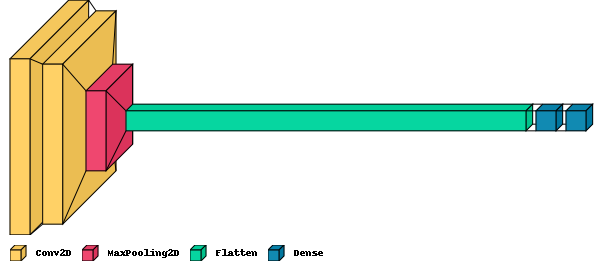

In [35]:
import visualkeras

visualkeras.layered_view(best_model , legend=True)


C:\Users\Poornima\AppData\Local\Temp\ipykernel_18224\2687959227.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **best_params)


31/31 [==============================] - 2s 48ms/step


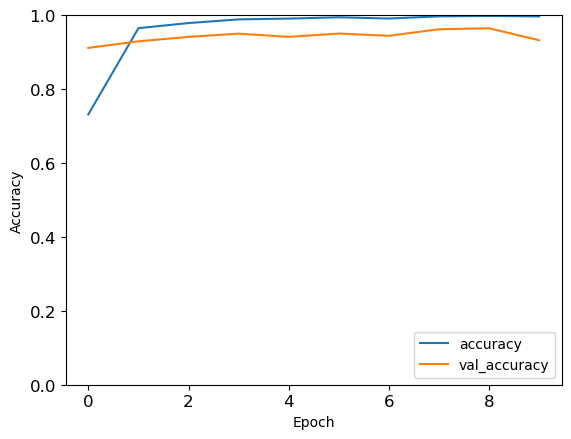

In [36]:
model = KerasClassifier(build_fn=create_cnn_ex2, **best_params)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model, 
                                                  'M3 Best 0.001',epochs=epochs,batch_size=batch_size)
plotHistory(history)

In [37]:
results_df

,Model,CV10_Mean_Accuracy,Train_accuracy,Test_accuracy
0,M1 LR 0.1,0.224458,0.229102,0.233010
1,M1 LR 0.01,0.739628,0.882353,0.765049
2,M1 LR 0.001,0.621156,0.978947,0.905825
3,M1 LR 0.0001,0.398349,0.723839,0.608091
4,M1 LR 0.00001,0.257069,0.402167,0.337864
5,M2 LR 0.001,0.383075,0.950980,0.863430
6,M3 LR 0.001 softmax,0.621878,0.987616,0.916181
7,M3 LR 0.001 sigmoid,0.598142,0.766460,0.736570
8,M3 LR 0.001 linear,0.104334,0.127761,0.157929
9,M5 LR 0.001,0.158720,0.302167,0.324595


In [38]:
results_df.to_csv("results_df_final", sep=',', index=False, encoding='utf-8')

In [39]:
y_pred=model.predict(x_train_reshaped)
calculate_metrics_and_mean(x_train_reshaped,y_train,y_pred,model)

31/31 [==============================] - 2s 52ms/step - loss: 17.4225 - accuracy: 0.0702


,precision,recall,f1-score,TPR,FPR,specificity,sensitivity,AUC,accuracy,CV mean,CV std
0,1.000000,0.714286,0.833333,0.714286,0.000000,1.000000,0.714286,0.0,0.985965,0.68999,0.278632
1,0.947099,1.000000,0.972831,1.000000,0.016600,0.983400,1.000000,0.0,NaN,NaN,NaN
2,1.000000,0.993333,0.996656,0.993333,0.000000,1.000000,0.993333,0.0,NaN,NaN,NaN
3,1.000000,0.999291,0.999645,0.999291,0.000000,1.000000,0.999291,0.0,NaN,NaN,NaN
4,0.997411,0.972727,0.984914,0.972727,0.000649,0.999351,0.972727,0.0,NaN,NaN,NaN
5,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.0,NaN,NaN,NaN
6,0.980926,1.000000,0.990371,1.000000,0.000750,0.999250,1.000000,0.0,NaN,NaN,NaN
7,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.0,NaN,NaN,NaN
8,1.000000,0.992593,0.996283,0.992593,0.000000,1.000000,0.992593,0.0,NaN,NaN,NaN
9,1.000000,0.992593,0.996283,0.992593,0.000000,1.000000,0.992593,0.0,NaN,NaN,NaN


### Comparing accuracy of all models 

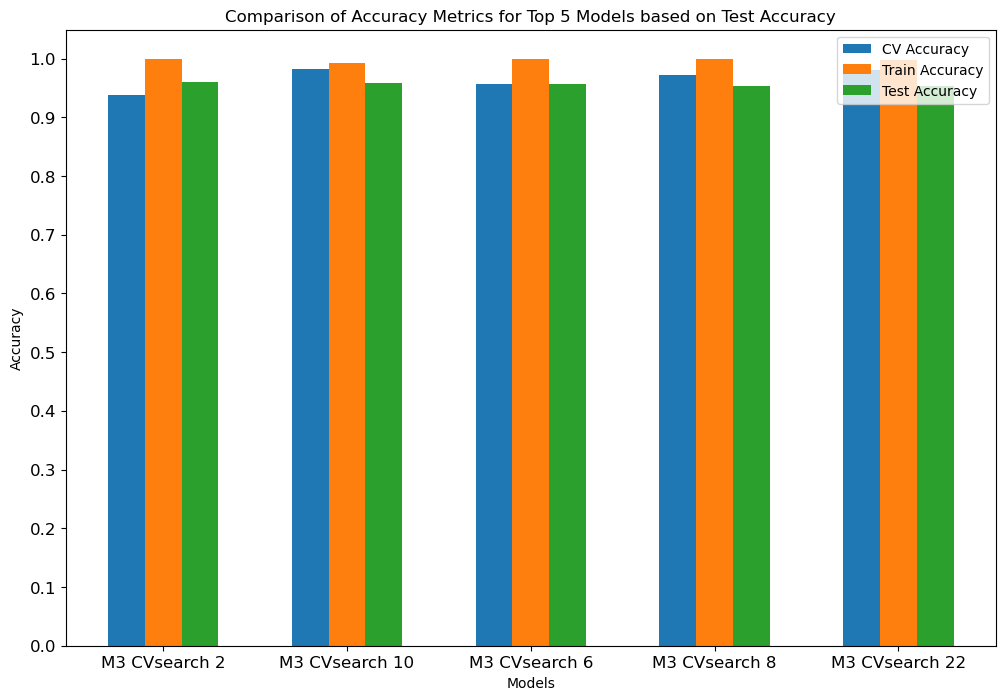

In [40]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 8))

# Sorting results dataframe such that test accuracy is high to low
sorted_results = results_df.sort_values(by='Test_accuracy', ascending=False)

top_5_results = sorted_results.head(5)


models = top_5_results['Model']
cv_accuracy = top_5_results['CV10_Mean_Accuracy']
train_accuracy = top_5_results['Train_accuracy']
test_accuracy = top_5_results['Test_accuracy']


bar_width = 0.2
index = range(len(models))

plt.bar(index, cv_accuracy, width=bar_width, label='CV Accuracy')
plt.bar([i + bar_width for i in index], train_accuracy, width=bar_width, label='Train Accuracy')
plt.bar([i + 2 * bar_width for i in index], test_accuracy, width=bar_width, label='Test Accuracy')

plt.yticks([i/10 for i in range(11)]) 

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy Metrics for Top 5 Models based on Test Accuracy')
plt.xticks([i + bar_width for i in index], models)
plt.legend()

plt.show()



### Visualizing CNN

In [41]:

keras_model = model.model
keras_model.summary()

Model: "sequential_375"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_706 (Conv2D)         (None, 44, 44, 32)        832       
                                                                 
 conv2d_707 (Conv2D)         (None, 40, 40, 32)        25632     
                                                                 
 max_pooling2d_386 (MaxPooli  (None, 20, 20, 32)       0         
 ng2D)                                                           
                                                                 
 flatten_375 (Flatten)       (None, 12800)             0         
                                                                 
 dense_750 (Dense)           (None, 64)                819264    
                                                                 
 dense_751 (Dense)           (None, 10)                650       
                                                    

(5, 5, 32, 32) -0.2929012 0.29141706


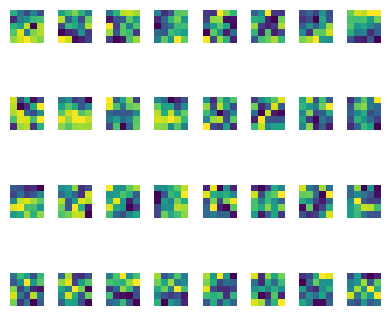

In [45]:
import math
import matplotlib.pyplot as plt
import numpy as np

def display_filters(model, layer_name, cols=5, interpolation=None):

    layer = model.get_layer(layer_name)
    weights = layer.get_weights()[0]
    print(weights.shape, weights.min(), weights.max())

  
    rows = math.ceil(weights.shape[3] / cols)   
    plt.figure(figsize=(4,4))

    i = 1
    for j in range(weights.shape[3]):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        # Display each filter
        plt.imshow(weights[:, :, 0, j], interpolation=interpolation)
        i += 1
    plt.tight_layout()
    plt.show()


layer_name = 'conv2d_707'
display_filters(model.model, layer_name, cols=8, interpolation="None")




### Running the best model on randomized images

97/97 [==============================] - 4s 43ms/step
Overall Test Accuracy: 0.9320388349514563


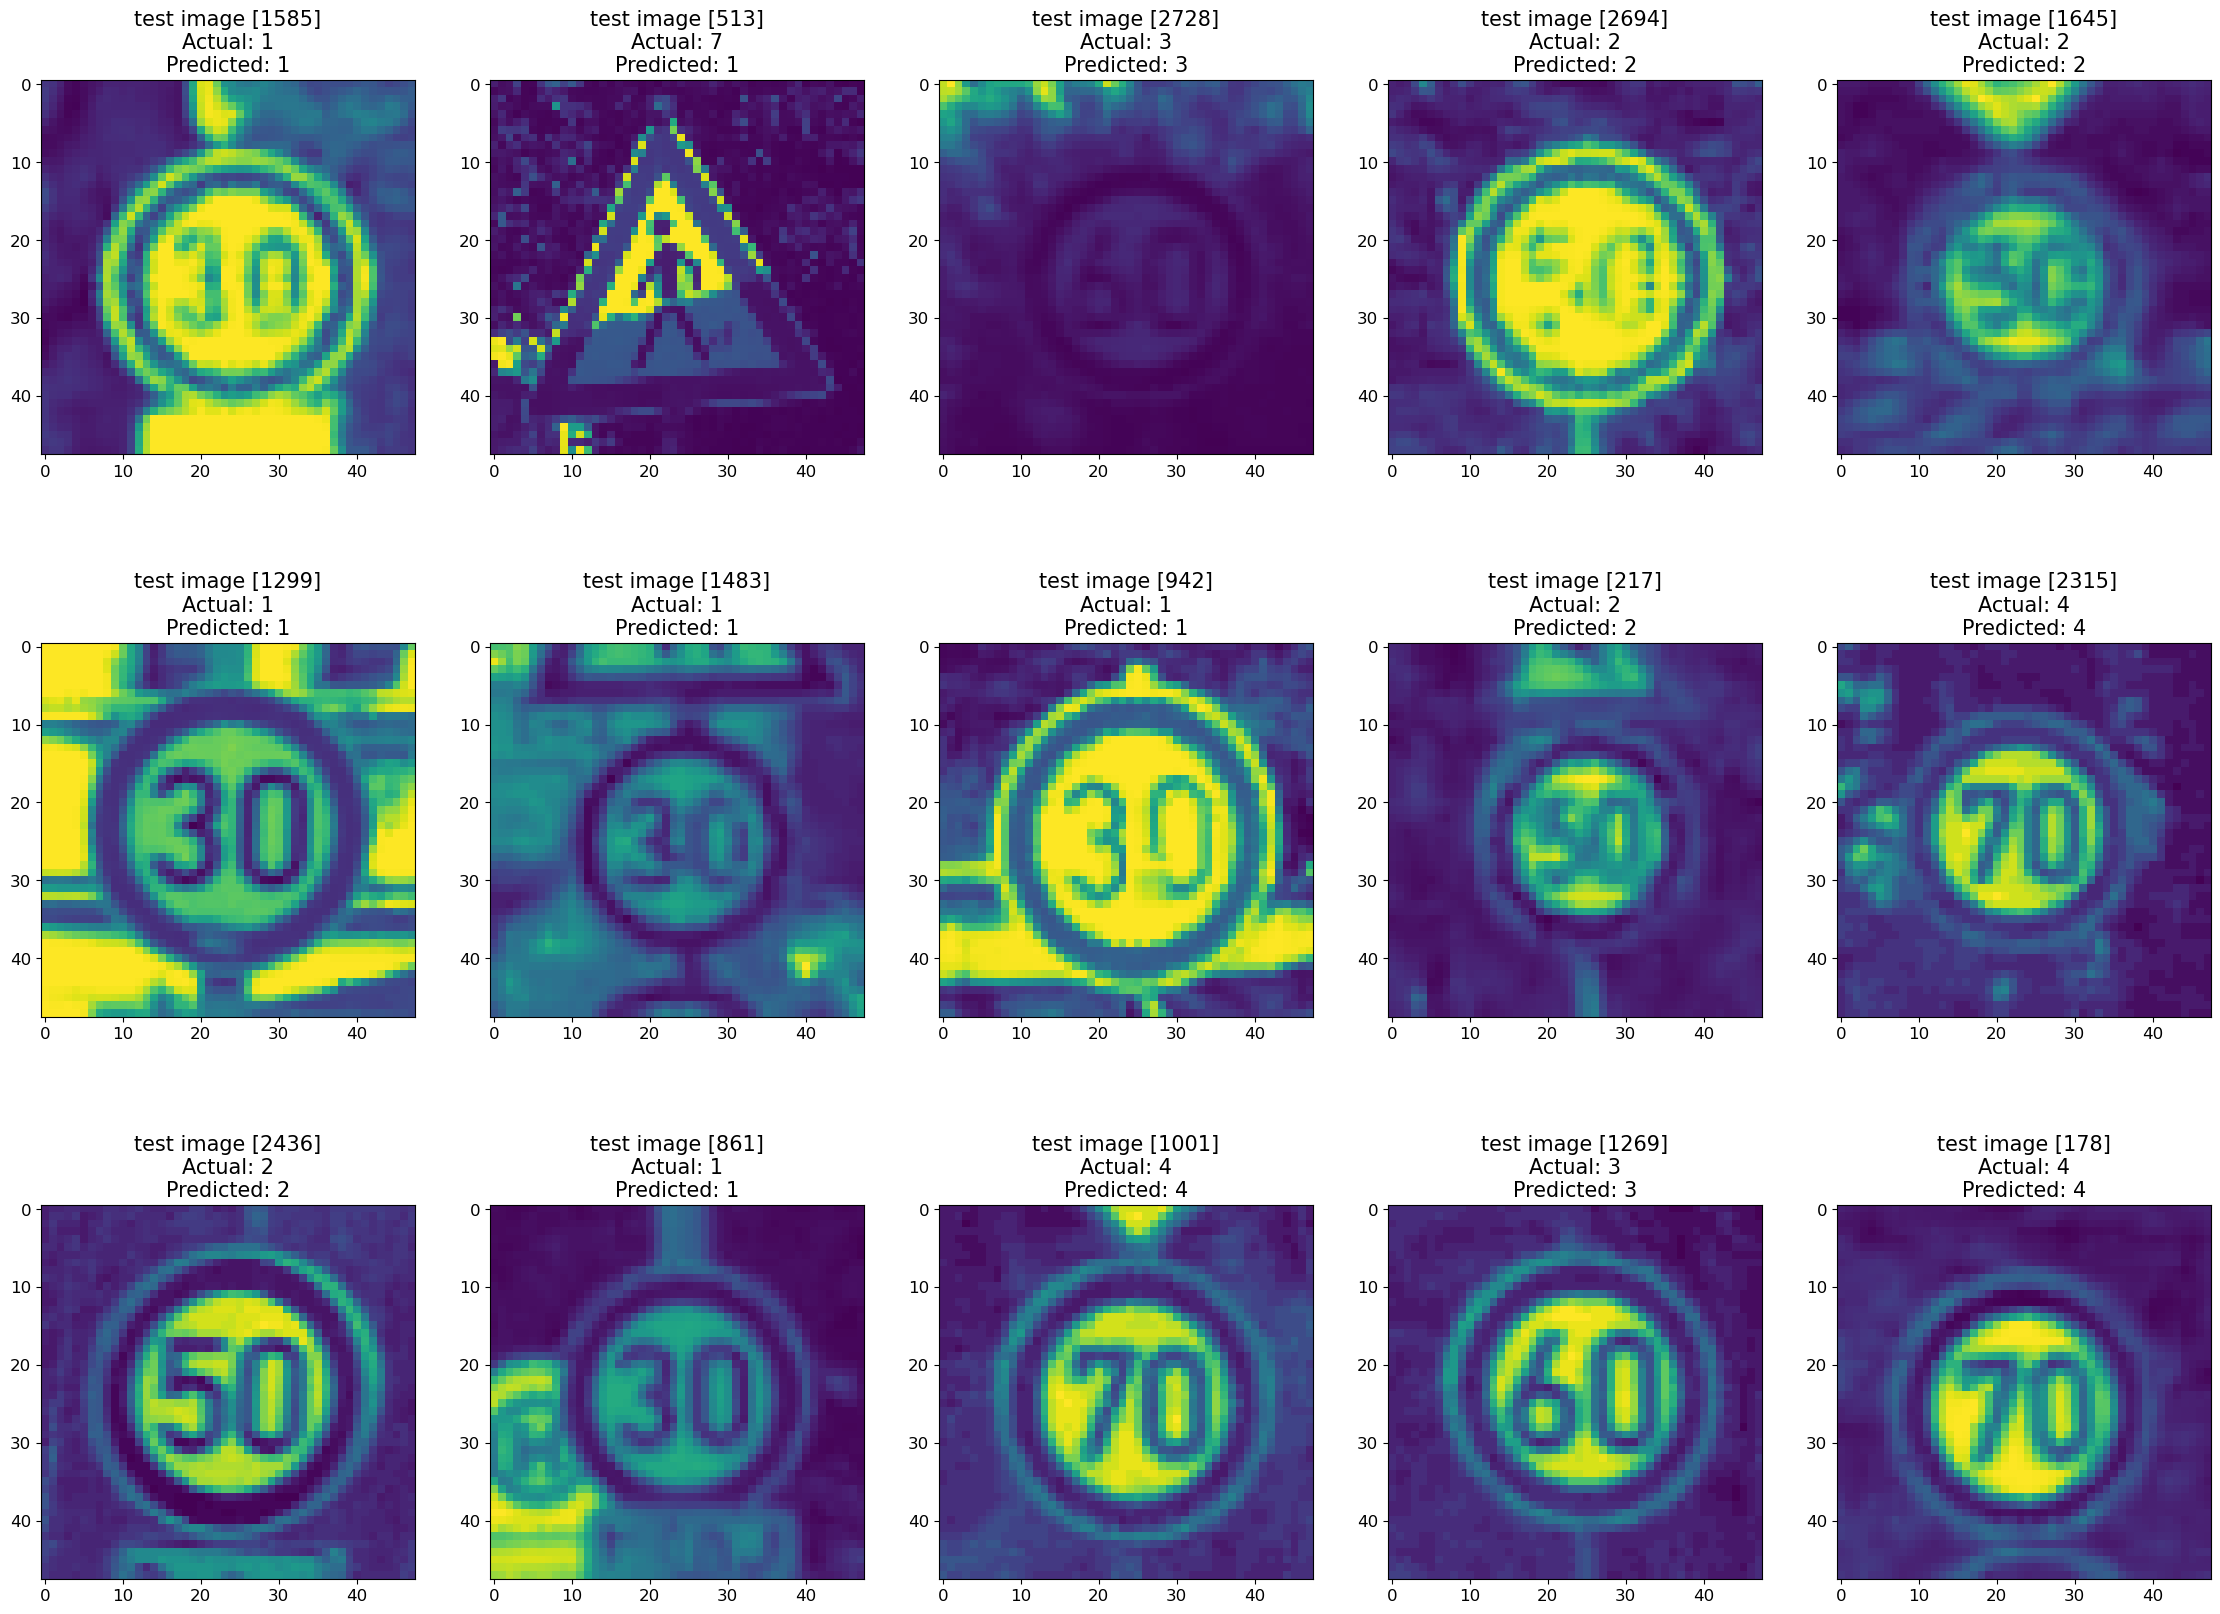

In [43]:
# Done 15 random images on the Test Dataset 
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import accuracy_score


def show_images_with_predictions(images, actual_values, predicted_values, title_texts):
    cols = 5
    rows = int(len(images) / cols) + 1
    plt.figure(figsize=(28, 28))
    index = 1
    
    for x in zip(images, actual_values, predicted_values, title_texts):
        image = x[0]
        actual_value = x[1]
        predicted_value = x[2]
        title_text = x[3]
        plt.subplot(rows, cols, index)
        
    
        height, width = int(np.sqrt(len(image))), int(np.sqrt(len(image)))
        image = image.reshape((height, width))
        
        plt.imshow(image)
        
        # Text showing actual and predicted value
        title_text += f'\nActual: {actual_value}\nPredicted: {predicted_value}'
        
        if (title_text != ''):
            plt.title(title_text, fontsize=15)
        index += 1


random_images = []
predicted_values = model.predict(x_test_reshaped)
actual_values = y_test

for i in range(0, 15):
    r = random.randint(0, len(x_test) - 1)
    random_images.append((x_test.iloc[r].values, actual_values.iloc[r,0], predicted_values[r], 'test image [' + str(r) + ']'))

show_images_with_predictions(list(map(lambda x: x[0], random_images)),
                              list(map(lambda x: x[1], random_images)),
                              list(map(lambda x: x[2], random_images)),
                              list(map(lambda x: x[3], random_images)))

# Calculate overall accuracy
test_accuracy = accuracy_score(actual_values, predicted_values)
print(f"Overall Test Accuracy: {test_accuracy}")

## Additional Exploration 